# Embeddings

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Input, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
import re
import string
import os
import shutil
import numpy as np
from utils import *
print(tf.__version__)
%load_ext tensorboard

2.4.0


In [2]:
text = 'the cat sat on the mat'

We could use one hot encoding, like this
<img src=https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/text/images/one-hot.png width=400/>

But this becomes really inefficient if we have a 10.000 word vocabulary....
So, maybe let's give each word a unique number

In [3]:
# first, we create a tensorflow dataset
from tensorflow.keras.layers import Input
text_dataset = tf.data.Dataset.from_tensor_slices(["the", "cat", "sat", 'mat', 'on'])

We have to set some hyperparameters for the creation of our embedding. 

- What is the maximum vocabulary size? This depenends on the problem at hand and the vocabulary available.
- What is a length at which we want to cut off the sequences? We wont be using RNNs, so we have to set a fixed length. If a sequence is too short, it will be padded with some token, eg zeros.
- What is the dimensionality of the embedding? This depends on the problem at hand. If we create an embedding with 50 dimensions, it can contain much more finegrained information as opposed to a 10D embedding, or 2D. But embeddings of 50 (or 300, or 1000) might also become too complex, and thus suffer from overfitting / long time to train etc.

In [4]:
vocab_size = 5 + 2  # Maximum vocab size . 5 for the words, 2 for a padding token and an unknown token.
max_len = 6  # Sequence length to pad the outputs to.
embedding_dims = 4

With these settings, we can initialize the vectorization of the words.

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Create the layer.
vectorize_layer = TextVectorization(
 max_tokens=vocab_size,
 output_mode='int',
 output_sequence_length=max_len)

Now that the vocab layer has been created, call `adapt` on the text-only dataset to create the vocabulary. You don't have to batch with this small example, but for large datasets this means we're not keeping spare copies of the dataset.

In [6]:
vectorize_layer.adapt(text_dataset.batch(64))

Let's have a look at the resulting vocabulary

In [7]:
vectorize_layer.get_vocabulary()

['', '[UNK]', 'the', 'sat', 'on', 'mat', 'cat']

And look at a minimal example of the vectorization in action

In [8]:
from tensorflow.keras.models import Sequential

# Create the model that uses the vectorize text layer
model = Sequential([
    # Start by creating an explicit input layer. It needs to have a shape of
    # (1,) (because we need to tell the model that there is exactly one string
    # input per batch), and the dtype needs to be 'string'.
    Input(shape=[1], dtype=tf.string),
    # The first layer in our model is the vectorization layer. After this
    # layer, we have a tensor of shape (batch_size, max_len) containing vocab
    # indices.
    vectorize_layer
])

In [9]:
# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
input_data = [["where sat the cat"], ["the cat sat on the mat"]]
model.predict(input_data)

array([[1, 3, 2, 6, 0, 0],
       [2, 6, 3, 4, 2, 5]])

Can you trace back the sentence encoding from the vocabulary?
Try to decode for yourself. Look at the sentence 'where sat the cat', look at the vocabulary we printed three cells back, and look at the result `[1,3,2,6,0,0]`.

- what happened with the word 'where'? Why is that?
- what happened with the length of the inputsentence?


We can feed this vectorized form to an embedding layer in the shape of `(batches x sequencelength)`. An Embedding layer will try to learn an encoding of the input. The learning will take place with regards to the output we feed the model, and the loss function.

The output of the Embedding layer will be `(batches x sequencelength x embedding_dimensionality)`. So, 32 sentences, each with a length of 10 words, will have a shape `(32,10)`. The ouput of the embedding will be `(32, 10, 4)` if you use a 4-dimensional embedding for every word.

<img src=https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/text/images/embedding2.png width=400/>

In [10]:
embedding_dimension = 5
model = Sequential([
    Input(shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(input_dim = vocab_size, output_dim = embedding_dimension)
])

In [11]:
result = model.predict(input_data)
result.shape

(2, 6, 5)

In [12]:
result[0] # result for the first sentence

array([[-0.00161499, -0.01573062,  0.02473227,  0.01795487, -0.04145768],
       [ 0.00980958, -0.03715442, -0.006073  ,  0.01385095, -0.00502083],
       [-0.02412613,  0.03301397, -0.02720314, -0.03016099,  0.04993695],
       [ 0.03905821, -0.00567815, -0.01388925, -0.02439894,  0.01914727],
       [-0.01323643, -0.03883352,  0.02732095, -0.04805093,  0.02395835],
       [-0.01323643, -0.03883352,  0.02732095, -0.04805093,  0.02395835]],
      dtype=float32)

We fed the model a sentence of 6 words. The output is a vector of 5 numbers for every word. You can look at this output as a way of generating features. For that part, it is similar to what we have been doing with `Conv1D` and `Conv2D` layers.

Another way to think about these embeddings, is as en encoding of the "meaning" of every word.

# Load the data
## Train-test split

In [13]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'README', 'test']

In [14]:
dataset_dir

'./aclImdb'

From the README of the dataset:

There are two top-level directories `[train/, test/]` corresponding to
the training and test sets. Each contains `[pos/, neg/]` directories for
the reviews with binary labels positive and negative.

Within these directories, reviews are stored in text files named following the
convention `[[id]_[rating].txt]` where `[id]` is a unique id and `[rating]` is
the star rating for that review on a 1-10 scale. For example, the file
`[test/pos/200_8.txt]` is the text for a positive-labeled test set
example with unique id 200 and star rating 8/10 from IMDb. The
`[train/unsup/]` directory has 0 for all ratings because the ratings are
omitted for this portion of the dataset.

In [15]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir) # these are the directories we obtained

['urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'pos',
 'urls_unsup.txt',
 'labeledBow.feat',
 'unsupBow.feat']

In [16]:
# this one should be removed, see README
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [17]:
# we make a train-test split, using a data generator
batch_size = 1024
seed = 123
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='training', seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, 
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


## Preprocessing the data

Check how the data looks

In [18]:
n = 200 # first n characters
for text_batch, label_batch in train_ds.take(1):
  for i in range(2):
    print("label:", label_batch[i].numpy(),"\ntextdata:", text_batch[i].numpy()[:n])

label: 0 
textdata: b'Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it '
label: 1 
textdata: b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved th'


Check the shapes

In [19]:
for x, y in train_ds:
    print(x.shape)
    print(y.shape)
    break
# you find the batchsize here

(1024,)
(1024,)


In [20]:
# autotune the prefetching for speedup
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Let's clean the text:
- to lowercase
- remove html
- remove punctuation

It is not always necessary to do this; the question is: does this information add information for the problem you want to solve? Or is it additional noise?

In [21]:
# the string library has a punctuation set available
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
# we can load that as a list, and make it a string again
punctuation = '[%s]' % string.punctuation
punctuation

'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'

In [23]:
punctuation = '[%s]' % string.punctuation

# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) # all tekst to lowercase
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # replace br with spaces
  return tf.strings.regex_replace(stripped_html, punctuation, '') # remove punctuation

With this in place, we can create a `TextVectorization` layer.

In [24]:
# Pick a vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## A first model
Let's create a full model.

The `TextVectorization` layer transforms strings into vocabulary indices. You have already initialized vectorize_layer as a TextVectorization layer and built it's vocabulary by calling adapt on text_ds. Now vectorize_layer can be used as the first layer of your end-to-end classification model, feeding tranformed strings into the Embedding layer.

The `Embedding` layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

The `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

In [25]:
result = {}

In [26]:
embedding_dim=16

model = Sequential([
    Input(shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


What do we see happening, in terms of shapes?
- the input data has the size `(batch x 1)`, because is a batch of sentences. The type is `tf.string`.
- the `text_vectorization` layer takes in a `tf.string`, removes the interpunction etc, and takes the first 100 words that will be encoded as integers. So the output is `(batch x sequencelength)`
- We now want to add meaningful features to every word. Because the text vectorization are just arbitrary numbers assigned to words. We want to learn meaningful encodings. So the `Embedding` layer does exactly that. We end with `(batch x sequencelength x embeddingdimension)`
- The `global_average_pooling1d` takes the average of the sequence. So, the embeddings of the 100 words are averaged, and the shape is changed to `(batch x average)`, where we have an average for every embedding dimension.

In the lesson on images, we also saw the `from_logits=True` option. A recap on how that works:

In [29]:
# we assume 2 classed as label, and a probability as ouput
y_true = [[1, 0], [0, 1]]
y_pred = [[0.7, 0.3], [0.4, 0.6]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
loss.numpy()

array([0.3566748, 0.5108254], dtype=float32)

In [30]:
# we assume two classes (binary) as label, sparse (because the logits and label must have the same shape)
# logits as ouput (ranging from [-Inf, Inf] instead of [0,1])
y_true = [[1], [0]]
y_pred = [[5.0], [-5.0]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
loss.numpy()

array([0.00671535, 0.00671535], dtype=float32)

You can play with the examples above to check your understanding of what is happening.

Now, let's train the model.

In [31]:
%%time
result['base'] = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10)

Epoch 1/10
20/20 [==============================] - 2s 84ms/step - loss: 0.6920 - accuracy: 0.5028 - val_loss: 0.6900 - val_accuracy: 0.4886
Epoch 2/10
20/20 [==============================] - 1s 61ms/step - loss: 0.6870 - accuracy: 0.5028 - val_loss: 0.6834 - val_accuracy: 0.4886
Epoch 3/10
20/20 [==============================] - 1s 60ms/step - loss: 0.6782 - accuracy: 0.5028 - val_loss: 0.6727 - val_accuracy: 0.4886
Epoch 4/10
20/20 [==============================] - 1s 60ms/step - loss: 0.6646 - accuracy: 0.5028 - val_loss: 0.6572 - val_accuracy: 0.4886
Epoch 5/10
20/20 [==============================] - 1s 61ms/step - loss: 0.6457 - accuracy: 0.5029 - val_loss: 0.6371 - val_accuracy: 0.4888
Epoch 6/10
20/20 [==============================] - 1s 61ms/step - loss: 0.6216 - accuracy: 0.5246 - val_loss: 0.6130 - val_accuracy: 0.5406
Epoch 7/10
20/20 [==============================] - 1s 60ms/step - loss: 0.5934 - accuracy: 0.5940 - val_loss: 0.5864 - val_accuracy: 0.6046
Epoch 8/10
20

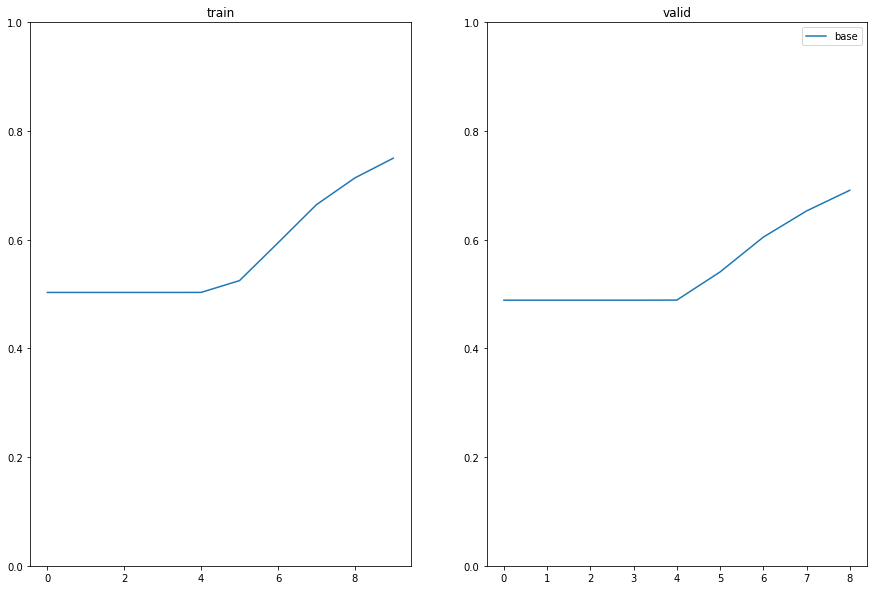

In [32]:
plot_results(result, metrics=['accuracy', 'val_accuracy'])

An embedding of 16 might be too low. Let's see what happens if we increase that.

In [33]:
embedding_dim=50

model = Sequential([
    Input(shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
result['emb50'] = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10)

Epoch 1/10
20/20 [==============================] - 1s 75ms/step - loss: 0.6911 - accuracy: 0.5028 - val_loss: 0.6875 - val_accuracy: 0.4886
Epoch 2/10
20/20 [==============================] - 1s 66ms/step - loss: 0.6826 - accuracy: 0.5028 - val_loss: 0.6753 - val_accuracy: 0.4886
Epoch 3/10
20/20 [==============================] - 1s 67ms/step - loss: 0.6650 - accuracy: 0.5028 - val_loss: 0.6526 - val_accuracy: 0.4886
Epoch 4/10
20/20 [==============================] - 1s 70ms/step - loss: 0.6363 - accuracy: 0.5207 - val_loss: 0.6207 - val_accuracy: 0.5428
Epoch 5/10
20/20 [==============================] - 1s 68ms/step - loss: 0.5972 - accuracy: 0.6126 - val_loss: 0.5817 - val_accuracy: 0.6326
Epoch 6/10
20/20 [==============================] - 1s 68ms/step - loss: 0.5509 - accuracy: 0.7039 - val_loss: 0.5394 - val_accuracy: 0.6932
Epoch 7/10
20/20 [==============================] - 1s 67ms/step - loss: 0.5015 - accuracy: 0.7589 - val_loss: 0.4993 - val_accuracy: 0.7356
Epoch 8/10
20

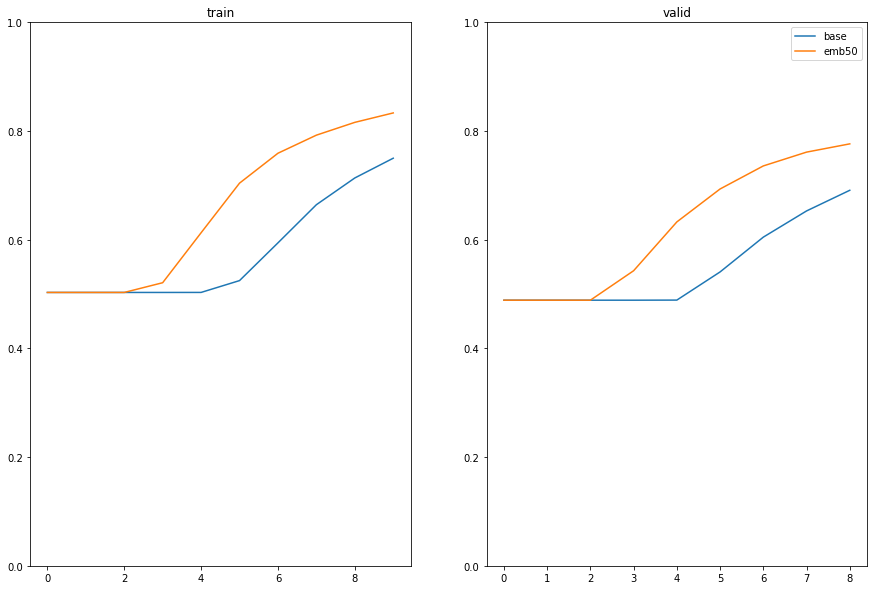

In [34]:
plot_results(result, metrics=['accuracy', 'val_accuracy'])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           500000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 500,833
Trainable params: 500,833
Non-trainable params: 0
_________________________________________________________________


And, in addition to that, we could toss in some Conv1D layers. As you can see, the embedding has a 3D output of `(batch x sequencelength x embeddings)`, and a `Conv1D` expects a 3D input, so that would work in terms of input-ouput shapes.

In [36]:
embedding_dim=50

model = Sequential([
    Input(shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
result['emb50_conv'] = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
20/20 [==============================] - 4s 182ms/step - loss: 0.6912 - accuracy: 0.5028 - val_loss: 0.6788 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 3s 174ms/step - loss: 0.6028 - accuracy: 0.6309 - val_loss: 0.4731 - val_accuracy: 0.7728
Epoch 3/15
20/20 [==============================] - 3s 172ms/step - loss: 0.3673 - accuracy: 0.8309 - val_loss: 0.4133 - val_accuracy: 0.8180
Epoch 4/15
20/20 [==============================] - 3s 172ms/step - loss: 0.2549 - accuracy: 0.8955 - val_loss: 0.4431 - val_accuracy: 0.8164
Epoch 5/15
20/20 [==============================] - 3s 173ms/step - loss: 0.1962 - accuracy: 0.9229 - val_loss: 0.5447 - val_accuracy: 0.8150
Epoch 6/15
20/20 [==============================] - 3s 169ms/step - loss: 0.1739 - accuracy: 0.9294 - val_loss: 0.5690 - val_accuracy: 0.7984
Epoch 7/15
20/20 [==============================] - 3s 174ms/step - loss: 0.1564 - accuracy: 0.9387 - val_loss: 0.6328 - val_accuracy: 0.7774
Epoch 

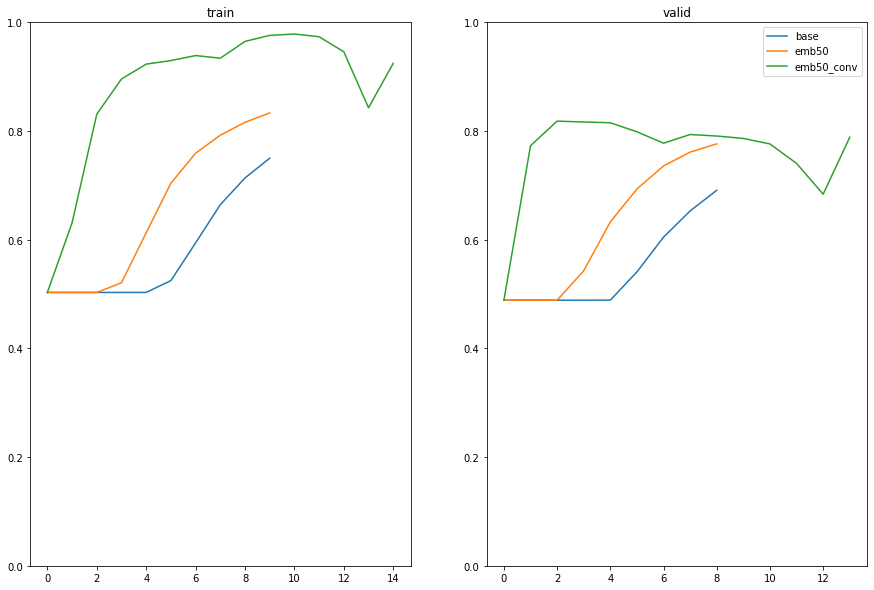

In [37]:
plot_results(result, metrics=['accuracy', 'val_accuracy'], ymax=1)

# Pretrained wordembeddings

[Glove](https://nlp.stanford.edu/projects/glove/) are pretrained, unsupervised word-embeddings. They are trained on corpuses of billions of words. The glove.6B is trained on 6 billion words from wikipedia.

The idea of these embeddings is a general understanding of language, where words that have the same meaning should be found close to eachother in the embedding-space. This is trained with the assumption that words that are found close to eachother in the text more often, have a similar meaning.

The example below is taken from the [keras documentation](https://keras.io/examples/nlp/pretrained_word_embeddings/)

In [38]:
#!wget -N http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -o ~/shared/glove.6B.zip -d ~/shared/

In [40]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "./shared/glove.6B.50d.txt"
)

We load the pretrained embeddings

In [41]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Obtain the vocabulary and index.

In [42]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

And rebuild the embeddingmatrix

In [43]:
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9890 words (110 misses)


In [44]:
embedding_matrix.shape

(10002, 50)

We can now load this matrix as the weights of our Embedding layer.

In [45]:
from tensorflow.keras.initializers import Constant
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=True,
)

Let's swap our untrained embedding layer with our pretrained one.

In [46]:
model = Sequential([
    Input(shape=[1], dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
%%time
result['pretrained'] = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=15)

Epoch 1/15
20/20 [==============================] - 4s 180ms/step - loss: 0.6941 - accuracy: 0.5028 - val_loss: 0.6930 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 3s 172ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6928 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 3s 174ms/step - loss: 0.6874 - accuracy: 0.5116 - val_loss: 0.6644 - val_accuracy: 0.6006
Epoch 4/15
20/20 [==============================] - 4s 180ms/step - loss: 0.6526 - accuracy: 0.6497 - val_loss: 0.6328 - val_accuracy: 0.6854
Epoch 5/15
20/20 [==============================] - 3s 174ms/step - loss: 0.6255 - accuracy: 0.7255 - val_loss: 0.6210 - val_accuracy: 0.7050
Epoch 6/15
20/20 [==============================] - 3s 173ms/step - loss: 0.6115 - accuracy: 0.7592 - val_loss: 0.6146 - val_accuracy: 0.7700
Epoch 7/15
20/20 [==============================] - 3s 170ms/step - loss: 0.6049 - accuracy: 0.7733 - val_loss: 0.6069 - val_accuracy: 0.7746
Epoch 

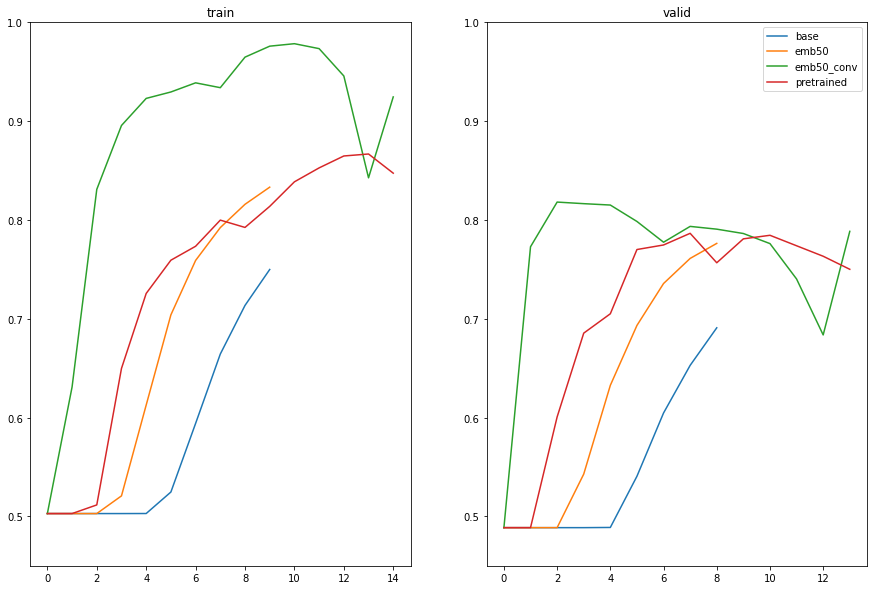

In [49]:
plot_results(result, ymax=1, ymin=0.45, metrics=['accuracy', 'val_accuracy'])

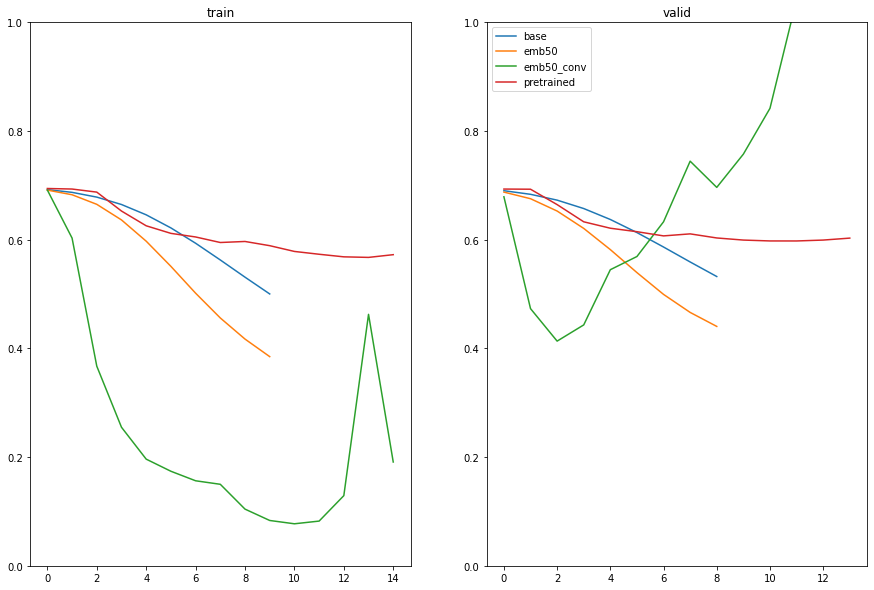

In [52]:
plot_results(result, ymin=0, ymax=1)

In this case, in terms of accuracy, our own embedding can outperforms the pretrained layer. But, the pretrained layer seem to protect against overfitting if we look at the loss. Still, training for just 2 epochs would give us higher accuracy without overfitting.

What do we learn from this? A custom embedding can be perfectly fine. This depends on the complexity of the task at hand, and how much the domain on which the embeddings are pretrained help the performance in the domain to which we want to transfer the learning.

## Using pretrained sentence embeddings

In addition to pretrained word-embeddings, we can also use pretrained sentence embeddings. From the paper [A SIMPLE BUT TOUGH-TO-BEAT BASELINE FOR SENTENCE EMBEDDINGS](https://openreview.net/pdf?id=SyK00v5xx):
    
> The success of neural network methods for computing word embeddings has motivated methods for generating semantic embeddings of longer pieces of text, such as sentences and paragraphs. Surprisingly, Wieting et al (ICLR’16) showed that such complicated methods are outperformed, especially in out-of-domain (transfer learning) settings, by simpler methods involving mild retraining of word embed- dings and basic linear regression. [...] The current paper goes further, showing that the following completely unsupervised sentence embedding is a formidable baseline: Use word embeddings computed using one of the popular methods on unlabeled corpus like Wikipedia, represent the sentence by a weighted average of the word vectors, and then modify them a bit using PCA/SVD

So, let's try!

In [53]:
import tensorflow_hub as hub
print("Version: ", tf.__version__) # 2.3.1
print("Eager mode: ", tf.executing_eagerly()) # True
print("Hub version: ", hub.__version__) # 0.10
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.1
Eager mode:  True
Hub version:  0.10.0
GPU is NOT AVAILABLE


from [tfhub](https://tfhub.dev/) we can download pretrained models. Lets grab the [nnlm-en-dim50](https://tfhub.dev/google/nnlm-en-dim50/2), which is a Token based text embedding trained on English Google News 7B corpus. The module takes a batch of sentences in a 1-D tensor of strings as input. Word embeddings are combined into sentence embedding.

In [54]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [55]:
model = Sequential([
    hub_layer,
    Dense(16, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_8 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
result['sentence_emb'] = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/15
20/20 [==============================] - 10s 507ms/step - loss: 0.6839 - accuracy: 0.5019 - val_loss: 0.6478 - val_accuracy: 0.5004
Epoch 2/15
20/20 [==============================] - 10s 481ms/step - loss: 0.6094 - accuracy: 0.5810 - val_loss: 0.5762 - val_accuracy: 0.6088
Epoch 3/15
20/20 [==============================] - 10s 479ms/step - loss: 0.5233 - accuracy: 0.7075 - val_loss: 0.4963 - val_accuracy: 0.7254
Epoch 4/15
20/20 [==============================] - 10s 477ms/step - loss: 0.4293 - accuracy: 0.8008 - val_loss: 0.4179 - val_accuracy: 0.8036
Epoch 5/15
20/20 [==============================] - 10s 486ms/step - loss: 0.3395 - accuracy: 0.8629 - val_loss: 0.3589 - val_accuracy: 0.8372
Epoch 6/15
20/20 [==============================] - 10s 479ms/step - loss: 0.2679 - accuracy: 0.8985 - val_loss: 0.3211 - val_accuracy: 0.8612
Epoch 7/15
20/20 [==============================] - 10s 482ms/step - loss: 0.2131 - accuracy: 0.9250 - val_loss: 0.2994 - val_accuracy: 0.8712

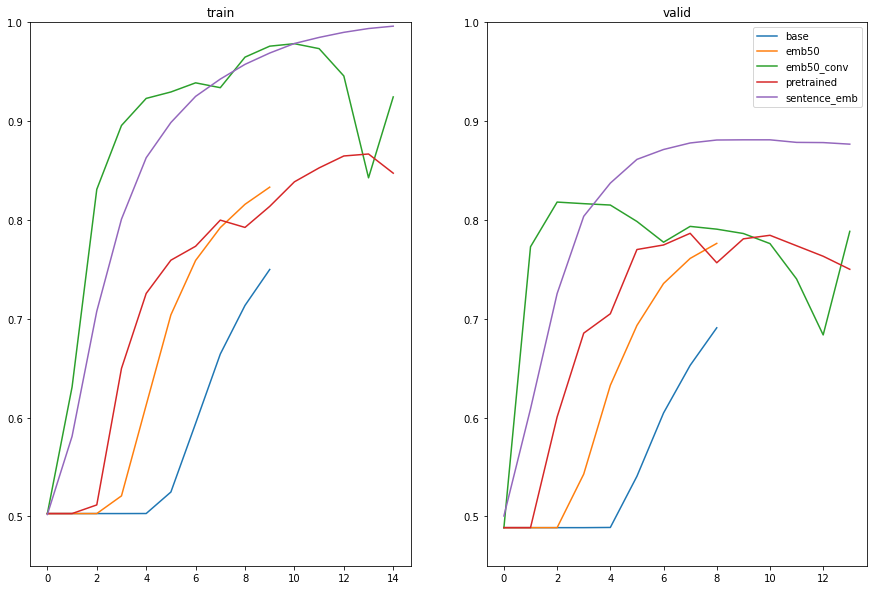

In [58]:
plot_results(result, ymax=1, ymin=0.45, metrics=['accuracy', 'val_accuracy'])

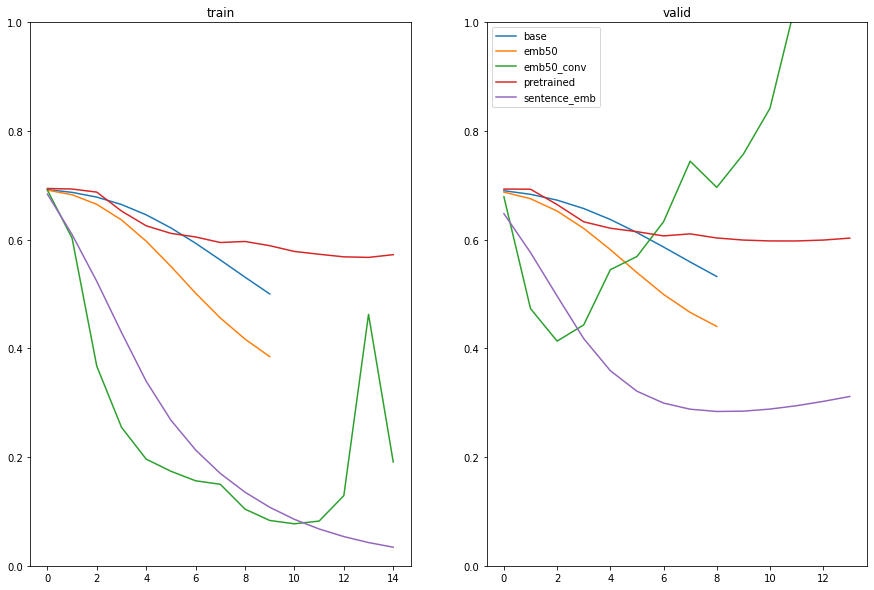

In [59]:
plot_results(result, ymin=0, ymax=1)

Now, that *is* a great improvement! This beats all other models. Lesson learned: a pretrained embedding can definitely improve your model a lot, if you can find the right embeddings for the task, trained with the right architecture. 

And what is the right architecture? NLP is evolving so hard (BERT, Transformers, GTP-3 etc) that it might pay off to spend some time on tracking the most recent developments available for your task at hand.

And pretrained embeddings are not always the best way to go, e.g. if you are dealing with a very specific domain. But often, when considering language, they help a lot.